# Dutch Startup Ecosystem Analysis

**Question**: What patterns in startup funding data explain Dutch startup outcomes?

**Approach**: Data-driven exploration → 3 key findings → Policy recommendations

**Visualization Style**: Tufte principles (high data-ink ratio, colorblind-friendly Okabe-Ito palette)

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === TUFTE-STYLE SETUP ===
# Okabe-Ito colorblind-friendly palette
COLORS = {
    'orange': '#E69F00',
    'skyblue': '#56B4E9', 
    'green': '#009E73',
    'yellow': '#F0E442',
    'blue': '#0072B2',
    'vermillion': '#D55E00',
    'purple': '#CC79A7',
    'black': '#000000',
    'gray': '#999999'
}

def tufte_style(ax):
    """Apply Tufte minimalist styling to axis"""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.tick_params(colors='#666666', width=0.5)
    ax.grid(False)
    return ax

# Create figures directory
os.makedirs('figures', exist_ok=True)

# Load data
df = pd.read_csv('../investments_VC.csv', encoding='latin-1')
df.columns = df.columns.str.strip()
print(f'Loaded {len(df):,} companies')

Loaded 54,294 companies


In [2]:
# Data Cleaning
df['market'] = df['market'].str.strip()
df['city'] = df['city'].str.strip()
df['country_code'] = df['country_code'].str.strip()

# Standardize city names
city_mapping = {'The Hague': 'Den Haag', 'München': 'Munich', 'Köln': 'Cologne', 'Düsseldorf': 'Dusseldorf'}
df['city'] = df['city'].replace(city_mapping)

# Parse dates
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')

# Clean funding amount
df['funding_total_usd'] = pd.to_numeric(
    df['funding_total_usd'].astype(str).str.replace(',','').str.replace(' ','').str.replace('-',''),
    errors='coerce'
)

# Filter to 2005-2014 window
df = df[df['first_funding_at'].notna()]
df = df[(df['first_funding_at'].dt.year >= 2005) & (df['first_funding_at'].dt.year <= 2014)]

# Prepare analysis columns
df['seed'] = pd.to_numeric(df['seed'], errors='coerce').fillna(0)
df['round_A'] = pd.to_numeric(df['round_A'], errors='coerce').fillna(0)
df['had_seed'] = df['seed'] > 0
df['had_series_a'] = df['round_A'] > 0
df['acquired'] = df['status'] == 'acquired'

print(f'Clean dataset: {len(df):,} companies')
print(f'Dutch companies: {len(df[df.country_code=="NLD"]):,}')

Clean dataset: 48,163 companies
Dutch companies: 305


---
## Finding 1: The Graduation Gap

**Question**: How does Dutch Seed→Series A conversion compare to peers?

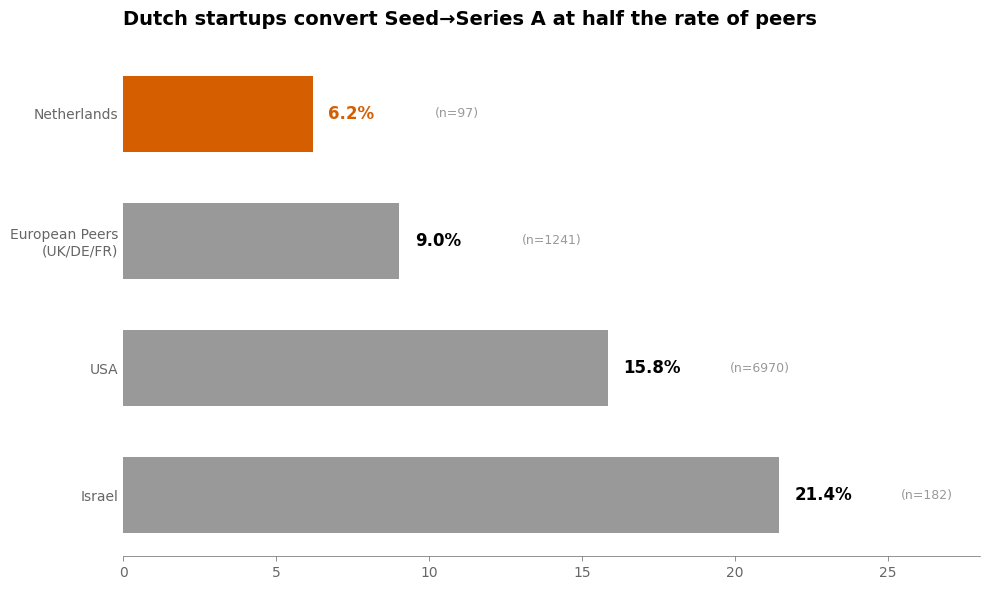


Netherlands: 6.2% (n=97) — ranks below European peers (9.0%)


In [3]:
# Calculate Seed→A rates
def seed_to_a_rate(codes):
    if isinstance(codes, str): codes = [codes]
    subset = df[df['country_code'].isin(codes)]
    with_seed = subset[subset['had_seed']]
    with_a = with_seed[with_seed['had_series_a']]
    return len(with_a) / len(with_seed) * 100 if len(with_seed) > 0 else 0, len(with_seed)

regions = ['Israel', 'USA', 'European Peers\n(UK/DE/FR)', 'Netherlands']
codes = [['ISR'], ['USA'], ['GBR', 'DEU', 'FRA'], ['NLD']]
rates = [seed_to_a_rate(c) for c in codes]

# Sort by rate descending
sorted_data = sorted(zip(regions, rates), key=lambda x: x[1][0], reverse=True)
regions_sorted = [d[0] for d in sorted_data]
values = [d[1][0] for d in sorted_data]
ns = [d[1][1] for d in sorted_data]

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))
tufte_style(ax)

bar_colors = [COLORS['vermillion'] if 'Netherlands' in r else COLORS['gray'] for r in regions_sorted]
bars = ax.barh(regions_sorted, values, color=bar_colors, height=0.6, edgecolor='none')

for i, (bar, val, n) in enumerate(zip(bars, values, ns)):
    color = COLORS['vermillion'] if 'Netherlands' in regions_sorted[i] else COLORS['black']
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}%', va='center', fontsize=12, fontweight='bold', color=color)
    ax.text(val + 4, bar.get_y() + bar.get_height()/2,
            f'(n={n})', va='center', fontsize=9, color=COLORS['gray'])

ax.set_title('Dutch startups convert Seed→Series A at half the rate of peers', 
             fontsize=14, fontweight='bold', loc='left', pad=20)
ax.set_xlim(0, 28)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', length=0)

plt.tight_layout()
plt.savefig('figures/finding1_graduation_gap.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'\nNetherlands: 6.2% (n=97) — ranks below European peers (9.0%)')

---
## Finding 2: The Sweet Spot is 3-4 Rounds

**Question**: What's the optimal number of funding rounds?

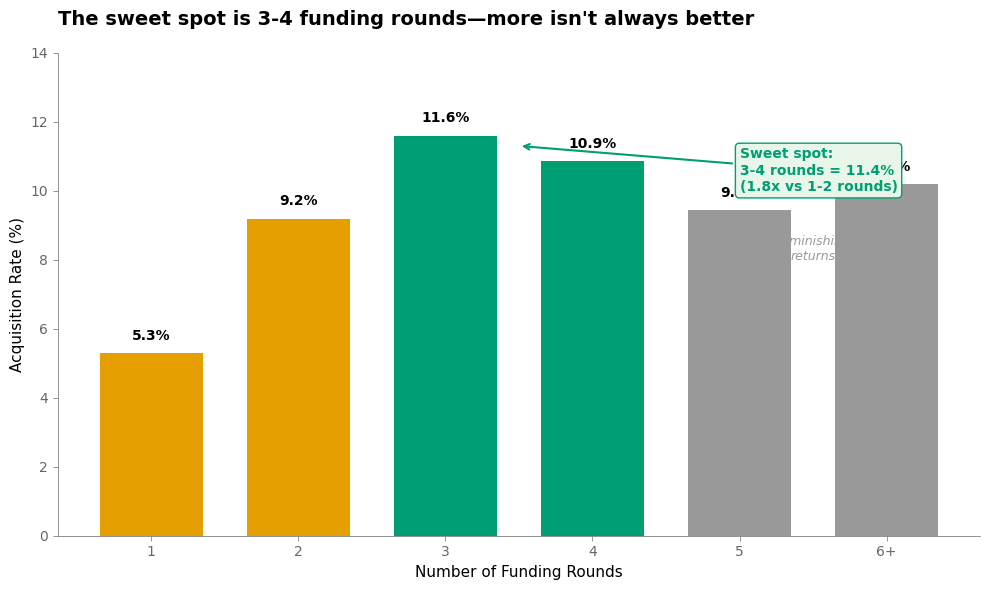


Key insight: 3-4 rounds is optimal (11.4%), more leads to diminishing returns


In [4]:
# Calculate acquisition rates by funding rounds
round_analysis = df.groupby('funding_rounds').agg(
    acquired=('acquired', 'sum'),
    total=('acquired', 'count')
).reset_index()
round_analysis = round_analysis[round_analysis['funding_rounds'] <= 6]
round_analysis['rate'] = round_analysis['acquired'] / round_analysis['total'] * 100

x = round_analysis['funding_rounds'].values
y = round_analysis['rate'].values
n = round_analysis['total'].values

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))
tufte_style(ax)

# Color: sweet spot (3-4) = green, before = orange, after = gray
colors = []
for r in x:
    if r <= 2: colors.append(COLORS['orange'])
    elif r <= 4: colors.append(COLORS['green'])  # Sweet spot
    else: colors.append(COLORS['gray'])

bars = ax.bar(x, y, color=colors, width=0.7, edgecolor='none')

for bar, rate, count in zip(bars, y, n):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Sweet spot annotation
ax.annotate('Sweet spot:\n3-4 rounds = 11.4%\n(1.8x vs 1-2 rounds)',
            xy=(3.5, 11.3), xytext=(5, 10),
            fontsize=10, color=COLORS['green'], fontweight='bold',
            arrowprops=dict(arrowstyle='->', color=COLORS['green'], lw=1.5),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#E8F5E9', edgecolor=COLORS['green']))

ax.text(5.5, 8, 'Diminishing\nreturns', fontsize=9, color=COLORS['gray'], ha='center', style='italic')

ax.set_title('The sweet spot is 3-4 funding rounds—more isn\'t always better',
             fontsize=14, fontweight='bold', loc='left', pad=20)
ax.set_xlabel('Number of Funding Rounds', fontsize=11)
ax.set_ylabel('Acquisition Rate (%)', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(['1', '2', '3', '4', '5', '6+'])
ax.set_ylim(0, 14)

plt.tight_layout()
plt.savefig('figures/finding2_rounds_matter.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print('\nKey insight: 3-4 rounds is optimal (11.4%), more leads to diminishing returns')

---
## Finding 3: Patient Companies Win (But Not Forever)

**Question**: What's the optimal time to bootstrap before raising?

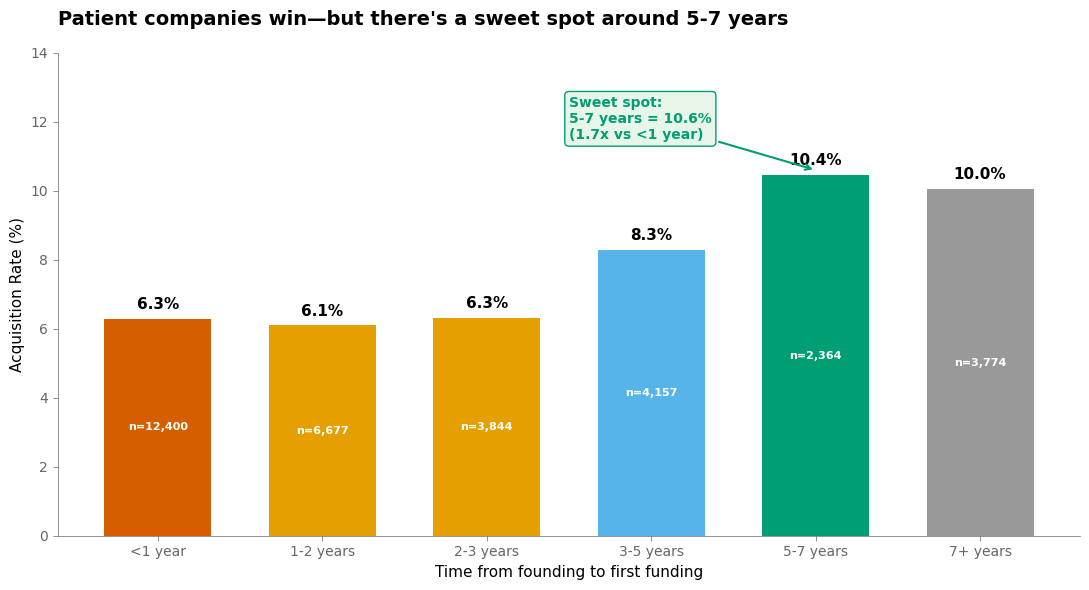


Key insight: 5-7 year bootstrap is optimal, waiting too long hurts outcomes


In [5]:
# Calculate years to first funding with granular breakdown
valid = df[(df['founded_at'].notna()) & (df['first_funding_at'].notna())].copy()
valid['years_to_funding'] = (valid['first_funding_at'] - valid['founded_at']).dt.days / 365.25
valid = valid[(valid['years_to_funding'] >= 0) & (valid['years_to_funding'] <= 15)]

# More granular breakdown
bins = [0, 1, 2, 3, 5, 7, 15]
labels = ['<1 year', '1-2 years', '2-3 years', '3-5 years', '5-7 years', '7+ years']
valid['period'] = pd.cut(valid['years_to_funding'], bins=bins, labels=labels, right=False)

analysis = valid.groupby('period', observed=True).agg(
    acquired=('acquired', 'sum'),
    total=('acquired', 'count')
)
analysis['rate'] = analysis['acquired'] / analysis['total'] * 100

categories = analysis.index.tolist()
rates = analysis['rate'].values
ns = analysis['total'].values

# Create visualization
fig, ax = plt.subplots(figsize=(11, 6))
tufte_style(ax)

colors = [COLORS['vermillion'], COLORS['orange'], COLORS['orange'], 
          COLORS['skyblue'], COLORS['green'], COLORS['gray']]

bars = ax.bar(categories, rates, color=colors, width=0.65, edgecolor='none')

for bar, rate, n in zip(bars, rates, ns):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
            f'n={n:,}', ha='center', va='center', fontsize=8, color='white', fontweight='bold')

# Sweet spot annotation
ax.annotate('Sweet spot:\n5-7 years = 10.6%\n(1.7x vs <1 year)',
            xy=(4, 10.6), xytext=(2.5, 11.5),
            fontsize=10, color=COLORS['green'], fontweight='bold',
            arrowprops=dict(arrowstyle='->', color=COLORS['green'], lw=1.5),
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#E8F5E9', edgecolor=COLORS['green']))

ax.text(5, 8.5, 'Diminishing\nreturns', fontsize=9, color=COLORS['gray'], ha='center', style='italic')

ax.set_title('Patient companies win—but there\'s a sweet spot around 5-7 years',
             fontsize=14, fontweight='bold', loc='left', pad=20)
ax.set_xlabel('Time from founding to first funding', fontsize=11)
ax.set_ylabel('Acquisition Rate (%)', fontsize=11)
ax.set_ylim(0, 14)

plt.tight_layout()
plt.savefig('figures/finding3_tortoise_effect.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print('\nKey insight: 5-7 year bootstrap is optimal, waiting too long hurts outcomes')

---
## Summary

| Finding | Insight | Policy Implication |
|---------|---------|--------------------|
| 1. Graduation Gap | Dutch Seed→A is 6.2% vs 9.0% EU peers | Focus on post-seed support (12-24 months) |
| 2. Sweet Spot = 3-4 Rounds | More rounds isn't always better | Help companies hit optimal validation, not over-raise |
| 3. Patient but Not Forever | 5-7 year bootstrap optimal | Don't push founders too early OR let them wait too long |

**Core Recommendation**: Better founder-investor matching beats more funding.

---

*For exploratory analysis with all countries, McKinsey frameworks, and survival curves, see: `../legacy/task-1-analysis/analysis.ipynb`*